# ***Imports***

In [288]:
import numpy as np
import random
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets

# ***Model Definition***

In [289]:
class CheaterCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=9, padding=4, stride=2),  # BIG kernel → global color
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=5, padding=2, stride=2),  # BIG kernel + stride → even more global color
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*7*7, 10)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# ***Loading the model***

In [290]:

def load_model(model_class, model_path, device):
    """
    Load model weights for Grad-CAM visualization.
    
    Args:
        model_class: The model class to instantiate
        model_path: Path to the .pth file
        device: torch device (cuda/cpu)
    
    Returns:
        model: Model in eval mode with requires_grad enabled for inputs
    """
    model = model_class().to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    
    # Eval mode: disables dropout, batch norm
    model.eval()
    
    # Keep requires_grad=True for input (needed for backprop in Grad-CAM)
    # but freeze all model parameters
    for param in model.parameters():
        param.requires_grad = False
    
    return model

# ***Color Palette & Coloring Functions***

In [ ]:
# Palette with custom colors
PALETTE = [
    [255, 0, 0],     # 0: Red
    [0, 255, 0],     # 1: Green
    [0, 0, 255],     # 2: Blue
    [255, 255, 0],   # 3: Yellow
    [255, 0, 255],   # 4: Magenta
    [0, 255, 255],   # 5: Cyan
    [255, 128, 0],   # 6: Orange
    [128, 0, 255],   # 7: Violet
    [139, 69, 19],   # 8: Brown
    [19, 139, 69]    # 9: Forest Green
]
BIAS_PROB = 0.95

def select_biased_color(label, is_hard_set):
    """Determines color based on 95/5 rule or inversion for Hard Set."""
    if is_hard_set:
        # Never use the shortcut color
        wrong_colors = [c for i, c in enumerate(PALETTE) if i != label]
        return random.choice(wrong_colors)
    else:
        # 95% shortcut, 5% random
        if random.random() < BIAS_PROB:
            return PALETTE[label]
        else:
            wrong_colors = [c for i, c in enumerate(PALETTE) if i != label]
            return random.choice(wrong_colors)

def color_foreground_stroke(grey_img, color_rgb):
    """
    grey_img: (28, 28) uint8 MNIST digit
    color_rgb: np.array([R, G, B]) in [0,255]

    Returns:
        (28, 28, 3) uint8 colored MNIST image
    """
    # normalize digit
    digit = grey_img.astype(np.float32) / 255.0

    # grayscale background (uninformative)
    bg = np.random.uniform(0.3, 0.6, (28, 28, 1))
    bg = np.repeat(bg, 3, axis=2)

    # normalize color
    color = np.array(color_rgb, dtype=np.float32) / 255.0

    # foreground stroke coloring
    img = bg * (1 - digit[..., None]) + digit[..., None] * color

    # small noise to avoid pixel-perfect cues
    img += np.random.randn(28, 28, 3) * 0.02
    img = np.clip(img, 0, 1)

    return (img * 255).astype(np.uint8)

# ***Loading and Colouring funcs***

In [296]:
def get_digit_from_dataset(digit_value, dataset_path='Class', train=False):
    """
    Get a random occurrence of a specific digit from .npy files in the 'Class' folder.
    
    Args:
        digit_value: The digit to find (0-9)
        dataset_path: Path to folder containing mnist_class_0.npy, ..., mnist_class_9.npy
        train: Included for compatibility (not used, since data is pre-split)
    
    Returns:
        digit: Grayscale image as numpy array (28, 28)
        label: The digit label
    """
    filename = os.path.join(dataset_path, f'mnist_class_{digit_value}.npy')
    
    if not os.path.exists(filename):
        print(f"File {filename} not found.")
        return None, None

    images = np.load(filename)  # Shape: (50, 28, 28)
    idx = np.random.randint(0, images.shape[0])  # Pick random index
    return images[idx], digit_value

In [297]:
def create_colored_digit(digit, label, is_hard_set=True):
    """
    Create a colored digit image using the biased color selection.
    
    Args:
        digit: Grayscale MNIST digit (28, 28) numpy array
        label: Ground truth label (0-9)
        is_hard_set: If True, never use the shortcut color
    
    Returns:
        colored_img: Colored digit as numpy array (28, 28, 3)
        img_tensor: PyTorch tensor ready for model input (1, 3, 28, 28)
    """
    # Select color and create colored image
    color = select_biased_color(label, is_hard_set)
    print(f"Colour:{color}")
    # color = PALETTE[7]
    colored_img = color_foreground_stroke(digit, color)
    
    # Convert to tensor
    img_tensor = torch.from_numpy(colored_img).float()
    img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)  # (1, 3, 28, 28)
    
    return colored_img, img_tensor

# ***Custom GradCam Functions***

In [ ]:
def register_gradcam_hooks(model, layer_index):
    """
    Register forward and backward hooks for Grad-CAM.
    
    Args:
        model: Neural network model
        layer_index: Index of the target layer in model.features
    
    Returns:
        features: Dictionary to store forward activations
        grads: Dictionary to store gradients
        hooks: List of hook handles for cleanup
    """
    features = {}
    grads = {}
    
    def forward_hook(module, inp, out):
        features["value"] = out
    
    def backward_hook(module, grad_in, grad_out):
        grads["value"] = grad_out[0]
    
    target_layer = model.features[layer_index]
    fwd_hook = target_layer.register_forward_hook(forward_hook)
    bwd_hook = target_layer.register_full_backward_hook(backward_hook)
    
    return features, grads, [fwd_hook, bwd_hook]

In [ ]:
def compute_gradcam(model, img, features, grads, device, 
                   image_size=(28, 28)):
    """
    Compute Grad-CAM heatmap for an image.
    
    Args:
        model: Neural network model
        img: Input image tensor (B, C, H, W)
        features: Dictionary storing forward activations (from hooks)
        grads: Dictionary storing gradients (from hooks)
        device: torch device
        image_size: Size to upsample heatmap to
    
    Returns:
        cam: Grad-CAM heatmap as numpy array (H, W)
        pred_class: Predicted class index
    """
    # Prepare image
    img = img.to(device)
    img.requires_grad = True
    
    # Forward pass
    model.zero_grad()
    logits = model(img)
    pred_class = logits.argmax(dim=1).item()
    
    # Use target class if specified, otherwise use predicted class
    # class_to_use = target_class if target_class is not None else pred_class
    
    # Backward pass
    logits[0, pred_class].backward()
    
    # Global average pooling of gradients
    weights = grads["value"].mean(dim=(2, 3), keepdim=True)
    
    # Weighted sum of feature maps
    cam = (weights * features["value"]).sum(dim=1, keepdim=True)
    
    # Apply ReLU
    cam = torch.relu(cam)
    
    # Normalize
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    
    # Upsample to image size
    cam = torch.nn.functional.interpolate(
        cam, size=image_size, mode="bilinear", align_corners=False
    )
    
    cam = cam[0, 0].detach().cpu().numpy()
    
    return cam, pred_class

In [ ]:
def apply_gradcam(img_tensor, model, device, layer_index=4):
    """
    Apply Grad-CAM to a colored digit tensor.
    
    Args:
        img_tensor: Image tensor (1, 3, 28, 28)
        model: Trained neural network model
        device: torch device
        layer_index: Layer index for Grad-CAM
    
    Returns:
        cam: Grad-CAM heatmap as numpy array
        pred_class: Predicted class
        hooks: List of hook handles (remember to remove them!)
    """
    # Register hooks
    features, grads, hooks = register_gradcam_hooks(model, layer_index)
    
    # Compute Grad-CAM
    cam, pred_class = compute_gradcam(model, img_tensor, features, grads, device)
    
    return cam, pred_class, hooks

# ***Actual GradCAM Code***

In [298]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def get_library_gradcam(input_tensor, model, target_layer):
    """Generates CAM using the pytorch-grad-cam library."""
    # Ensure model is in eval mode
    model.eval()
    
    # 1. Initialize GradCAM with the library
    # Note: target_layers must be a list
    cam_algorithm = GradCAM(model=model, target_layers=[target_layer])
    
    # 2. Define target (None defaults to highest scoring class)
    # This ensures both methods look at the same prediction
    grayscale_cam = cam_algorithm(input_tensor=input_tensor, targets=None)
    
    # Take the first image in batch
    return grayscale_cam[0, :]

# ***Visualising GradCAM***

In [295]:
def visualize_gradcam(img, cam, pred_class=None, figsize=(12, 6)):
    """
    Display original image and Grad-CAM heatmap side by side.
    
    Args:
        img: Input image tensor (B, C, H, W) or (C, H, W)
        cam: Grad-CAM heatmap as numpy array (H, W)
        pred_class: Predicted class for title (optional)
        figsize: Figure size
    """
    # Handle batch dimension
    if img.dim() == 4:
        img_np = img[0].detach().cpu().permute(1, 2, 0).numpy()
    else:
        img_np = img.detach().cpu().permute(1, 2, 0).numpy()
    
    # Normalize image
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    
    # Create subplot
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Original image
    axes[0].imshow(img_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    # Grad-CAM heatmap
    im = axes[1].imshow(cam, cmap="jet")
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis("off")
    
    # Add colorbar
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    
    if pred_class is not None:
        fig.suptitle(f"Predicted Class: {pred_class}", fontsize=14)
    
    plt.tight_layout()
    plt.show()   

# ***Usage Examples***

Colour:[255, 0, 0]


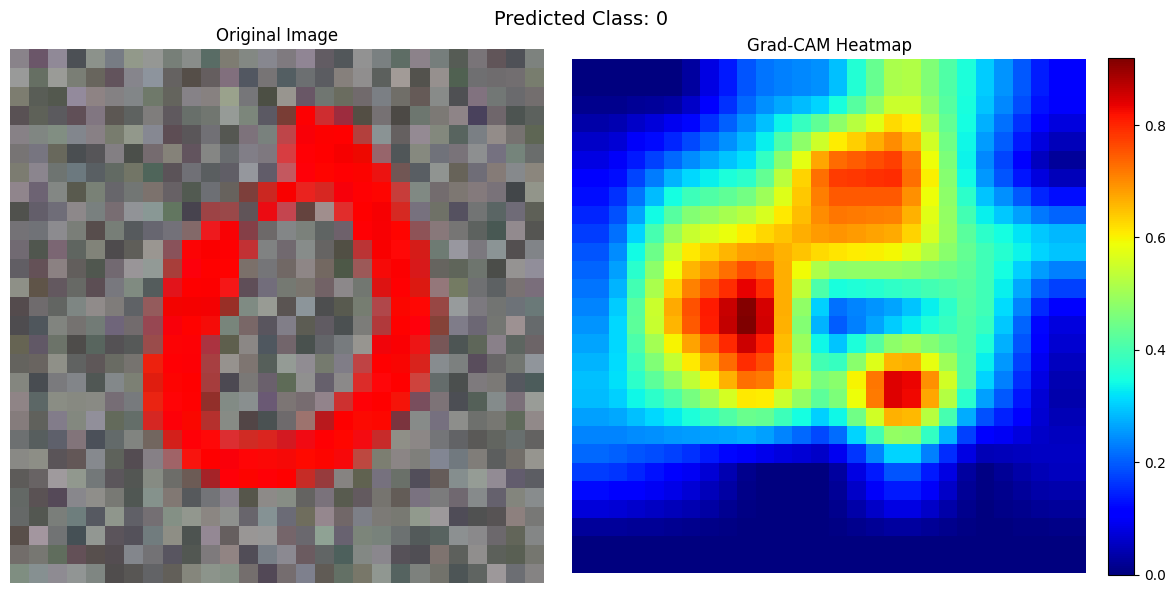

In [ ]:
# Loading model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Models = "Models"
model_path = os.path.join(Models, "cheater_cnn3_24.pth")

model = load_model(CheaterCNN, model_path, device)

# Get digit from dataset
digit, label = get_digit_from_dataset(0)

# Color the digit
colored_img, img_tensor = create_colored_digit(digit, label, is_hard_set=False) #If u want comparision with random coloring

# Example 3: Apply Grad-CAM (make sure model is loaded)
if 'model' in locals():
    cam, pred_class, hooks = apply_gradcam(img_tensor, model, device, layer_index=4)
    visualize_gradcam(img_tensor, cam, pred_class)

    # Uncomment if u want comparision with actual GRAD-CAM
    # target_layer = list(model.modules())[4] 
    # lib_cam = get_library_gradcam(img_tensor, model, target_layer)
    # visualize_gradcam(img_tensor, lib_cam, pred_class)
    for hook in hooks:
        hook.remove()
else:
    print("Model not loaded. Use load_model_for_gradcam() first.")
